# 作業 : (Kaggle)鐵達尼生存預測 
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 觀察降低偏態的影響

# [作業重點]
- 觀察使用log1p降偏態時, 對於分布與迴歸分數的影響 (In[6], Out[6])
- 修正區塊中的資料問題後, 觀察以box-cox降偏態, 對於分布與迴歸分數的影響 (In[7], Out[7])

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

data_path = '../data/'
df_train = pd.read_csv(data_path + 'titanic_train.csv')
df_test = pd.read_csv(data_path + 'titanic_test.csv')

train_Y = df_train['Survived']
ids = df_test['PassengerId']
df_train = df_train.drop(['PassengerId', 'Survived'] , axis=1)
df_test = df_test.drop(['PassengerId'] , axis=1)
df = pd.concat([df_train,df_test])
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(0)
MMEncoder = MinMaxScaler()
train_num = train_Y.shape[0]
df.head()

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


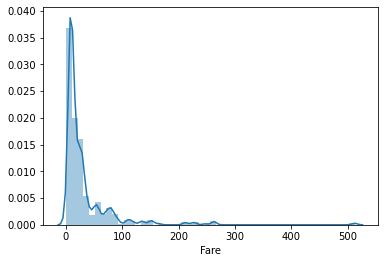

In [3]:
# 顯示 Fare 與目標值的散佈圖
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(df['Fare'][:train_num])
plt.show()

In [4]:
# 計算基礎分數
df_mm = MMEncoder.fit_transform(df)
train_X = df_mm[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7015378821166279

# 作業1 
* 試著在鐵達尼的票價 (Fare) 欄位中使用對數去偏 (log1p) , 結果是否更好?

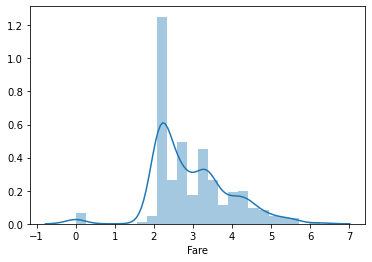

0.710545477371163

In [5]:
# 將 Fare 取 log1p 後, 看散佈圖, 並計算分數
df_fixed = copy.deepcopy(df)

df_fixed['Fare'] = np.log1p(df_fixed['Fare'])

sns.distplot(df_fixed['Fare'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)

train_X = df_fixed[:train_num]
estimator = LogisticRegression()

cross_val_score(estimator, train_X, train_Y, cv=5).mean()

In [6]:
df['Fare'].describe()

count    1309.000000
mean       33.270043
std        51.747063
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

# 作業2
* 最後的 boxcox 區塊直接執行會造成錯誤, 起因為輸入值有負值(或0), 請問如何修正後可以使用 boxcox? (Hint : 試圖修正資料)

In [11]:
# 將 Fare 取 boxcox 後, 執行會有 error, 輸入值為 0 的部分 +1 修正後，即可執行
df_temp = copy.deepcopy(df)
for i in range(len(df_temp['Fare'])):
    if df_temp['Fare'].iloc[i] == 0:
        df_temp['Fare'].iloc[i] = df_temp['Fare'].iloc[i] + 1

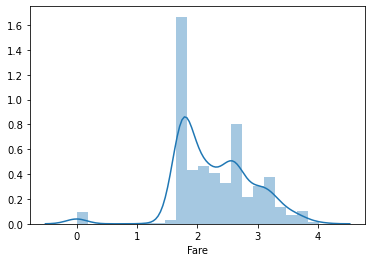

0.7094218818655451

In [8]:
# 將 Fare 取 boxcox 後, 看散佈圖, 並計算分數 (執行會有 error, 請試圖修正)
from scipy import stats,special
df_fixed = copy.deepcopy(df_temp)

df_fixed['Fare'] = stats.boxcox(df_fixed['Fare'])[0] 
sns.distplot(df_fixed['Fare'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

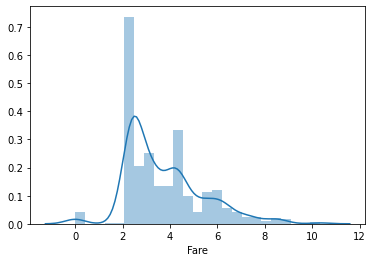

0.7105392003012992

In [9]:
# # 將 Fare 取 boxcox (box-cox : alpha=0.15)後, 看散佈圖, 並計算分數 
df_fixed = copy.deepcopy(df_temp)

df_fixed['Fare'] = stats.boxcox(df_fixed['Fare'], lmbda=0.15)
sns.distplot(df_fixed['Fare'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

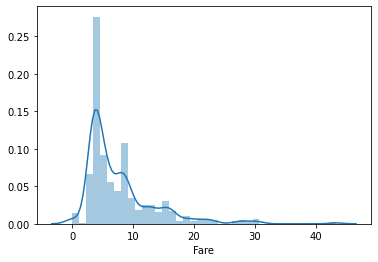

0.7060448182788275

In [10]:
# 將 Fare 取 sqrt (box-cox : alpha=0.5) 後, 看散佈圖, 並計算分數
df_fixed = copy.deepcopy(df_temp)

df_fixed['Fare'] = stats.boxcox(df_fixed['Fare'], lmbda=0.5)
sns.distplot(df_fixed['Fare'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()